# library imports

In [551]:
import pandas as pd 
import numpy as np
import os
from datetime import datetime
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

# Load our data

In [552]:
ratings = {'Rating': [], 'Date': [], 'Resort': []}
for file in os.listdir('comments/'):
    filepath = os.path.join('comments/', file)
    df = pd.read_csv(filepath)
    ratings['Rating'] = ratings['Rating']+df['Rating'].values.tolist()
    ratings['Date'] = ratings['Date']+df['Date'].values.tolist()
    ratings['Resort'] = ratings['Resort']+[file.split('.')[0] if len(file.split('.'))==2
                                           else file.split('.')[0]+'.'+file.split('.')[1] for i in range(df.shape[0])]

In [553]:
ratings = pd.DataFrame(ratings)
ratings.head()

,Rating,Date,Resort
0,4,2017-04-22 03:53:09,Charlotte
1,5,2017-06-11 03:54:51,Charlotte
2,5,2017-10-18 07:23:51,Charlotte
3,4,2017-12-04 09:57:32,Charlotte
4,4,2017-12-08 06:26:21,Charlotte


In [554]:
ratings['Resort'].unique()

array(['Charlotte', 'Mt. Buller', 'Mt. Hotham', 'Mt. Stirling',
       'Perisher', 'Selwyn', 'Thredbo'], dtype=object)

In [555]:
ratings['Resort']=ratings['Resort'].map(lambda x: 'Charlotte Pass' if x=='Charlotte' else x)

# Data transformations

In [556]:
# These are artificial dates for the ratings
# If a rating is made at week1 in a year, it is marked to be on the first date of the week
def compute_custom_week(date):
    date = datetime.strptime(date,"%Y-%m-%d %H:%M:%S")
    week1_start = pd.to_datetime(f"{date.year}-06-09")
    days_diff = (date - week1_start).days

    week_num = (days_diff // 7) + 1

    return 'week'+str(week_num) if week_num >= 1 and week_num<=15 else None  

In [557]:
compute_custom_week(ratings['Date'].values[0])

In [558]:
ratings['Week'] = ratings['Date'].apply(lambda x:compute_custom_week(x))

In [559]:
ratings = ratings[~ratings['Week'].isnull()]

In [560]:
ratings

,Rating,Date,Resort,Week
1,5,2017-06-11 03:54:51,Charlotte Pass,week1
19,1,2018-08-19 05:10:19,Charlotte Pass,week11
20,1,2018-08-26 00:55:01,Charlotte Pass,week12
35,5,2019-06-09 11:49:33,Charlotte Pass,week1
36,5,2019-06-20 11:50:03,Charlotte Pass,week2
...,...,...,...,...
9559,2,2025-08-27 11:34:04,Thredbo,week12
9560,4,2025-08-27 12:16:21,Thredbo,week12
9561,5,2025-08-29 04:46:27,Thredbo,week12
9562,5,2025-08-29 12:18:15,Thredbo,week12


In [561]:
# Make Year as a feature for the ease of data processing later
ratings['Year'] = ratings['Date'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").year)

In [562]:
ratings = ratings.groupby(['Resort','Week', 'Year'])['Rating'].mean()

In [563]:
# Generate the dataset
ratings.reset_index().to_csv('ratings.csv')

# More Analysis on the ratings
## Visualization on ratings changement

In [564]:
ratings = pd.DataFrame(ratings.reset_index())
ratings['week_num'] = ratings['Week'].apply(lambda x: int(x[-1]))
ratings = ratings.sort_values(['Resort', 'week_num', 'Year'])

In [565]:
ratings.isnull().sum()

Resort      0
Week        0
Year        0
Rating      0
week_num    0
dtype: int64

In [566]:
ratings

,Resort,Week,Year,Rating,week_num
3,Charlotte Pass,week10,2020,5.000000,0
4,Charlotte Pass,week10,2021,5.000000,0
5,Charlotte Pass,week10,2022,3.500000,0
6,Charlotte Pass,week10,2025,5.000000,0
0,Charlotte Pass,week1,2017,5.000000,1
...,...,...,...,...,...
504,Thredbo,week9,2021,3.800000,9
505,Thredbo,week9,2022,4.692308,9
506,Thredbo,week9,2023,4.625000,9
507,Thredbo,week9,2024,4.600000,9


In [567]:
ratings.dtypes

Resort       object
Week         object
Year          int64
Rating      float64
week_num      int64
dtype: object

In [568]:
ratings = ratings[ratings['Year']>2013]

In [569]:
ratings.head()

,Resort,Week,Year,Rating,week_num
3,Charlotte Pass,week10,2020,5.0,0
4,Charlotte Pass,week10,2021,5.0,0
5,Charlotte Pass,week10,2022,3.5,0
6,Charlotte Pass,week10,2025,5.0,0
0,Charlotte Pass,week1,2017,5.0,1


In [570]:
ratings['Date'] = pd.to_datetime(ratings['Year'].astype(str) + '-06-09') + pd.to_timedelta((ratings['week_num']) * 7, unit='D')

C:\Users\Huawei\AppData\Local\Temp\ipykernel_74076\2824894695.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['Date'] = pd.to_datetime(ratings['Year'].astype(str) + '-06-09') + pd.to_timedelta((ratings['week_num']) * 7, unit='D')


In [571]:
ratings.tail()

,Resort,Week,Year,Rating,week_num,Date
504,Thredbo,week9,2021,3.800000,9,2021-08-11
505,Thredbo,week9,2022,4.692308,9,2022-08-11
506,Thredbo,week9,2023,4.625000,9,2023-08-11
507,Thredbo,week9,2024,4.600000,9,2024-08-11
508,Thredbo,week9,2025,4.000000,9,2025-08-11


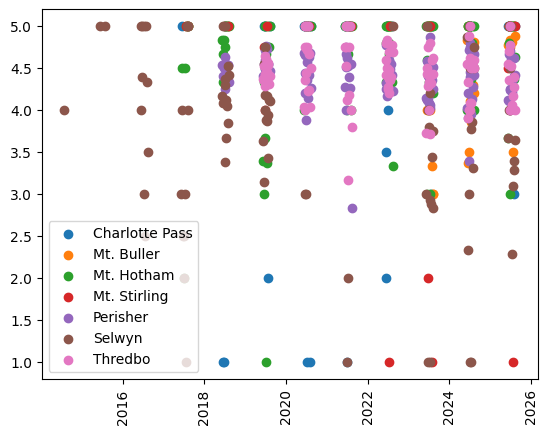

In [572]:
fig, ax= plt.subplots(1,1)
for x in ratings.Resort.unique():
    data = ratings.loc[ratings['Resort']==x]
    data = data.sort_values('Date')
    data = data.sort_values(['week_num', 'Year'])
    ax.scatter(data['Date'], data['Rating'], label = x)
plt.xticks(rotation=90)
plt.legend()

## Aggregate ratings with visitation dataset

In [573]:
visit_aus = pd.read_excel('2025 Allianz Datathon Dataset.xlsx', sheet_name='Visitation Data')

In [574]:
visit_aus = visit_aus.melt(value_vars=['Mt. Baw Baw', 'Mt. Stirling', 'Mt. Hotham', 'Falls Creek', 	'Mt. Buller',  'Selwyn',
	                       'Thredbo', 'Perisher',  'Charlotte Pass'], id_vars=['Year', 'Week'])

In [575]:
visit_aus_mu = visit_aus.groupby(['variable', 'Week', 'Year']).value.mean().reset_index()

In [576]:
visit_aus_mu[(visit_aus_mu['variable']=='Charlotte Pass') & (visit_aus_mu['Week']==3)]

,variable,Week,Year,value
22,Charlotte Pass,3,2014,230.0
23,Charlotte Pass,3,2015,501.0
24,Charlotte Pass,3,2016,1096.0
25,Charlotte Pass,3,2017,842.0
26,Charlotte Pass,3,2018,1264.0
27,Charlotte Pass,3,2019,992.0
28,Charlotte Pass,3,2020,133.0
29,Charlotte Pass,3,2021,1307.0
30,Charlotte Pass,3,2022,2385.0
31,Charlotte Pass,3,2023,1607.0


In [577]:
ratings['week_num'] = ratings['week_num']+1
combined_visit_ratings = visit_aus_mu.merge(ratings, left_on=['variable', 'Week', 'Year'], right_on=['Resort', 'week_num', 'Year'])

C:\Users\Huawei\AppData\Local\Temp\ipykernel_74076\2632842855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['week_num'] = ratings['week_num']+1


In [578]:
for x in combined_visit_ratings['Resort'].unique():
    data = combined_visit_ratings[combined_visit_ratings['Resort']==x]
    data = data.sort_values(by=['Date'])
    result = pearsonr(data['value'], data['Rating'])
    print(f'Pearson Correlation on n_visits and Ratings at resort {x} has a stats of {round(result.statistic, 3)} with pval of {round(result.pvalue, 3)}')

Pearson Correlation on n_visits and Ratings at resort Charlotte Pass has a stats of 0.015 with pval of 0.944
Pearson Correlation on n_visits and Ratings at resort Mt. Buller has a stats of 0.055 with pval of 0.812
Pearson Correlation on n_visits and Ratings at resort Mt. Hotham has a stats of 0.001 with pval of 0.993
Pearson Correlation on n_visits and Ratings at resort Mt. Stirling has a stats of -0.097 with pval of 0.731
Pearson Correlation on n_visits and Ratings at resort Perisher has a stats of 0.122 with pval of 0.228
Pearson Correlation on n_visits and Ratings at resort Selwyn has a stats of -0.18 with pval of 0.094
Pearson Correlation on n_visits and Ratings at resort Thredbo has a stats of -0.077 with pval of 0.475


# Web Crawling on Skii information dataset